## Set up dataset

In [34]:
conda install pytorch torchvision==0.4.0 cuda100 -c pytorch

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [35]:
from torch.hub import load_state_dict_from_url

In [36]:
pip install robustness

In [37]:
conda install pillow

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\32456\anaconda3\envs\r

  added / updated specs:
    - pillow


The following packages will be UPDATED:

  pillow                               6.1.0-py37hdc69c19_0 --> 9.2.0-py37hdc2b20a_1


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [38]:
conda install pillow=6.1

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\32456\anaconda3\envs\r

  added / updated specs:
    - pillow=6.1


The following packages will be DOWNGRADED:

  pillow                               9.2.0-py37hdc2b20a_1 --> 6.1.0-py37hdc69c19_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done





==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [39]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [40]:
ATTACK_EPS = 0.5
ATTACK_STEPSIZE = 0.1
ATTACK_STEPS = 10
NUM_WORKERS = 8
BATCH_SIZE = 10

In [41]:
import torch as ch
from robustness.datasets import CIFAR
ds = CIFAR('/tmp')

In [42]:
import tensorflow as tf

## Instantiate model

In [43]:
from robustness.model_utils import make_and_restore_model
model, _ = make_and_restore_model(arch='resnet50', dataset=ds,
             resume_path='C:/Users/32456/robust/newest/Cifar AT model/cifar_l2_0_5(Done).pt')
model.eval()
pass

=> loading checkpoint 'C:/Users/32456/robust/newest/Cifar AT model/cifar_l2_0_5(Done).pt'
=> loaded checkpoint 'C:/Users/32456/robust/newest/Cifar AT model/cifar_l2_0_5(Done).pt' (epoch 153)


## Set up loaders

In [44]:
train_loader2, test_loader2 = ds.make_loaders(workers=0, batch_size=10)
_, (im2, label2) = next(enumerate(train_loader2))

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [45]:
im2.shape

torch.Size([10, 3, 32, 32])

In [46]:
_, test_loader1 = ds.make_loaders(workers=0, batch_size=10)

_, (im, label) = next(enumerate(test_loader1))

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


## Generating untargeted adversarial examples

In [47]:
kwargs = {
    'constraint':'2', # use L2-PGD
    'eps': ATTACK_EPS, # L2 radius around original image
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'do_tqdm': True,
}

In [48]:
import torch as ch
from robustness.datasets import CIFAR
from robustness.model_utils import make_and_restore_model

In [49]:
attack_kwargs = {
   'constraint': 'inf', # L-inf PGD
   'eps': 0.05, # Epsilon constraint (L-inf norm)
   'step_size': 0.01, # Learning rate for PGD
   'iterations': 100, # Number of PGD steps
   'targeted': True # Targeted attack
}

In [50]:
_, test_loader1 = ds.make_loaders(workers=0, batch_size=10)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [51]:
im1, label1 = next(iter(test_loader1))

In [52]:
im1.shape

torch.Size([10, 3, 32, 32])

In [53]:
target_label1 = (label1 + ch.randint_like(label1, high=9)) % 10

In [54]:
device = ch.device("cuda" if ch.cuda.is_available() else "cpu")

In [55]:
adv_out1, adv_im1 = model(im1.to(device), target_label1.to(device), make_adv=True, **attack_kwargs)

In [56]:
_, im1_adv = model(im1.to(device), label1.to(device), make_adv=True, **kwargs)

Current loss: 0.9896228909492493: 100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


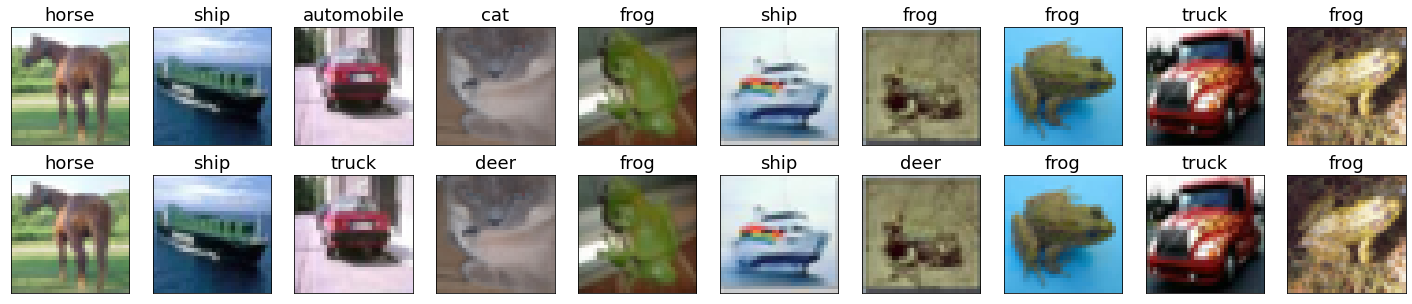

In [57]:
from robustness.tools.vis_tools import show_image_row
from robustness.tools.label_maps import CLASS_DICT

# Get predicted labels for adversarial examples
pred, _ = model(im1_adv)
label_pred = ch.argmax(pred, dim=1)

# Visualize test set images, along with corresponding adversarial examples
show_image_row([im1.cpu(), im1_adv.cpu()],
         tlist=[[CLASS_DICT['CIFAR'][int(t)] for t in l] for l in [label1, label_pred]],
         fontsize=18,
         filename='./adversarial_example_CIFAR.png')

## Targeted adversarial examples

In [21]:
kwargs = {
    'constraint':'2',
    'eps': ATTACK_EPS,
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'targeted': True,
    'do_tqdm': True
}

In [22]:
targ = ch.zeros_like(label1)

In [23]:
_, im1_adv = model(im1.to(device), targ.to(device), make_adv=True, **kwargs)

Current loss: 4.231689929962158: 100%|██████████| 10/10 [00:00<00:00, 13.90it/s]


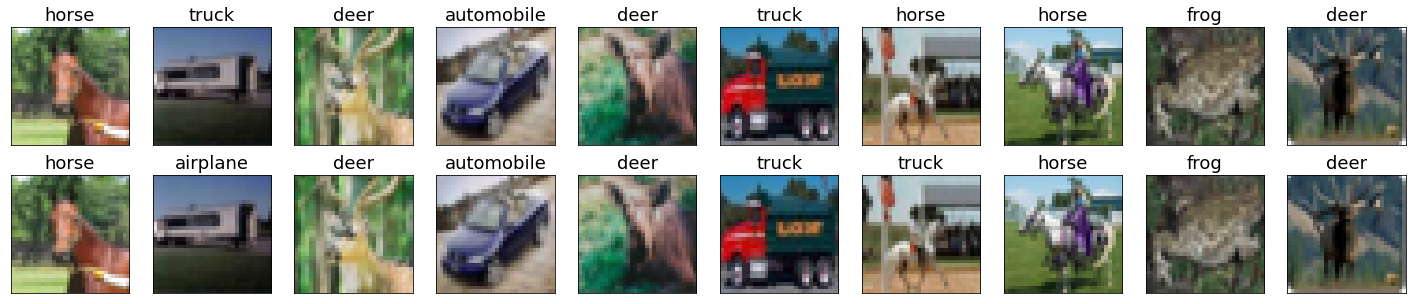

In [24]:
# Visualize test set images, along with corresponding adversarial examples
show_image_row([im1.cpu(), im1_adv.cpu()],
         tlist=[[CLASS_DICT['CIFAR'][int(t)] for t in l] for l in [label1, label_pred]],
         fontsize=18,
         filename='./adversarial_example_CIFAR.png')

## Custom Input Manipulation (Representation Inversion)

In [12]:
def inversion_loss(model, inp, targ):
    # Compute representation for the input
    _, rep = model(inp, with_latent=True, fake_relu=True)
    # Normalized L2 error w.r.t. the target representation
    loss = ch.div(ch.norm(rep - targ, dim=1), ch.norm(targ, dim=1))
    return loss, None

In [13]:
kwargs = {
    'custom_loss': inversion_loss,
    'constraint':'2',
    'eps': 1000,
    'step_size': 1,
    'iterations': 1000,
    'targeted': True,
    'do_tqdm': True,
}

In [14]:
train_loader1, test_loader1 = ds.make_loaders(workers=0, batch_size=50000)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [15]:
_, (im_inv, label_inv) = next(enumerate(test_loader1)) # Images to invert

In [21]:
im_inv.shape

torch.Size([10000, 3, 32, 32])

In [22]:
label_inv.shape

torch.Size([10000])

In [2]:
import numpy

In [3]:
import numpy as np

In [5]:
import torch
import torch as ch
import torchvision

In [26]:
df = numpy.save("trob.l5", label_inv.cpu().numpy())

In [27]:
df = numpy.save("tim_inv5", im_inv.cpu().numpy())
im_inv = np.load('tim_inv5.npy')
im_inv=ch.from_numpy(im_inv)

In [28]:
i=10

In [29]:
im_seed = ch.clamp(ch.randn_like(im_inv) / 20 + 0.5, 0, 1)

In [30]:
with ch.no_grad():
    (_, rep_inv0), _ = model(im_inv[0:10].to(device), with_latent=True)  # Corresponding representation
_, im_matched0 = model(im_seed[0:10].to(device), rep_inv0.to(device), make_adv=True, **kwargs)
for t in range(4999):
    with ch.no_grad():
        (_, rep_inv), _ = model(im_inv[i:i+10].to(device), with_latent=True)  # Corresponding representation
    _, im_matched = model(im_seed[i:i+10].to(device), rep_inv.to(device), make_adv=True, **kwargs)
    im_matched0 = torch.cat((im_matched, im_matched0), 0)   
    i=i+10

Current loss: 0.1074138805270195: 100%|██████████| 1000/1000 [01:35<00:00, 10.52it/s]


Current loss: 0.080231212079525: 100%|██████████| 1000/1000 [01:35<00:00, 10.51it/s] 


Current loss: 0.08478933572769165: 100%|██████████| 1000/1000 [01:35<00:00, 10.51it/s]


Current loss: 0.09259836375713348: 100%|██████████| 1000/1000 [01:35<00:00, 10.49it/s]


Current loss: 0.09712918102741241: 100%|██████████| 1000/1000 [01:35<00:00, 10.47it/s]


Current loss: 0.09724076092243195: 100%|██████████| 1000/1000 [01:35<00:00, 10.50it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM

In [31]:
df = numpy.save("trob5", im_matched0.cpu().numpy())

In [6]:
im_inv = np.load('tim_inv5.npy')

In [7]:
im_inv.shape

(10000, 3, 32, 32)

In [8]:
trob5 = np.load('trob5.npy')

In [9]:
trob5.shape

(10000, 3, 32, 32)

In [10]:
label_inv =np.load('trob.l5.npy')

In [11]:
label_inv.shape

(10000,)

In [87]:
i=0
t=9990
for j in range(1000):
  label_inv[i:i+10]=label_inv[i+t:i+t+10]
  t=t-20
  i=i+10

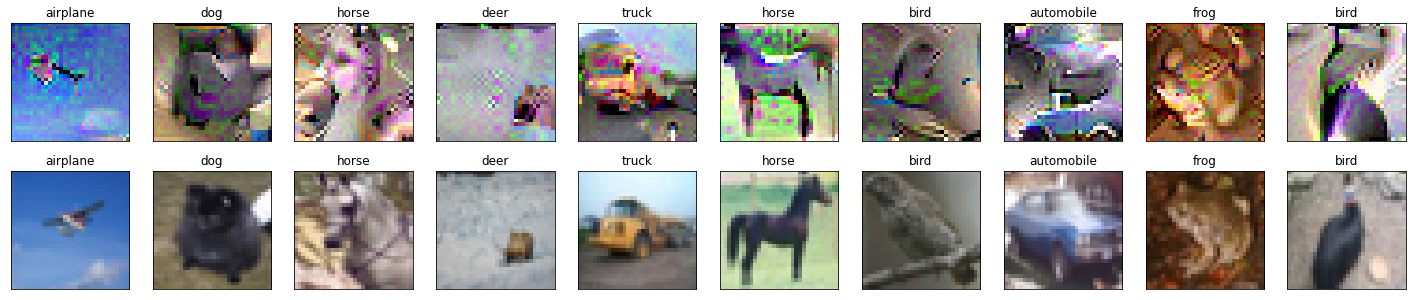

In [89]:
show_image_row([ch.from_numpy(trob5[10:20]), ch.from_numpy(im_inv[9980:9990])],
         tlist=[[CLASS_DICT['CIFAR'][int(t)] for t in l] for l in [label_inv[9980:9990], label_inv[9980:9990]]],)